In [1]:
%%HTML 
<script>
    function luc21893_refresh_cell(cell) {
        if( cell.luc21893 ) return;
        cell.luc21893 = true;
        console.debug('New code cell found...' );
        
        var div = document.createElement('DIV');            
        cell.parentNode.insertBefore( div, cell.nextSibling );
        div.style.textAlign = 'right';
        var a = document.createElement('A');
        div.appendChild(a);
        a.href='#'
        a.luc21893 = cell;
        a.setAttribute( 'onclick', "luc21893_toggle(this); return false;" );

        cell.style.visibility='hidden';
        cell.style.position='absolute';
        a.innerHTML = '[show code]';        
                
    }
    function luc21893_refresh() {                
        if( document.querySelector('.code_cell .input') == null ) {            
            // it apeears that I am in a exported html
            // hide this code
            var codeCells = document.querySelectorAll('.jp-InputArea')
            codeCells[0].style.visibility = 'hidden';
            codeCells[0].style.position = 'absolute';                        
            for( var i = 1; i < codeCells.length; i++ ) {
                luc21893_refresh_cell(codeCells[i].parentNode)
            }
            window.onload = luc21893_refresh;
        }                 
        else {
            // it apperas that I am in a jupyter editor
            var codeCells = document.querySelectorAll('.code_cell .input')
            for( var i = 0; i < codeCells.length; i++ ) {
                luc21893_refresh_cell(codeCells[i])
            }            
            window.setTimeout( luc21893_refresh, 1000 )
        }        
    }
    
    function luc21893_toggle(a) {
        if( a.luc21893.style.visibility=='hidden' ) {
            a.luc21893.style.visibility='visible';        
            a.luc21893.style.position='';
            a.innerHTML = '[hide code]';
        }
        else {
            a.luc21893.style.visibility='hidden';        
            a.luc21893.style.position='absolute';
            a.innerHTML = '[show code]';
        }
    }
    
    luc21893_refresh()
</script>

# Title

<img src='title.PNG'>

# Highlights

## New Time Series Algorithm

A new time series algorithm is introduced in this project. A brief description of what `prophet` is is discussed below.

Facebook developed Prophet,  an open sourcing forecasting tool that tries to capture daily, weekly and yearly seasonality along with holiday effects, implementing an additive regression model. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is also robust to missing data and shifts in the trend, and typically handles outliers well.


## Implementing Prophet using the `fbprophet` library

The `prophet` algorithm can be implemented using the `fbprophet` library for python. The project uses the functions built in the library to implement the algorithm.

## The Match is a close one!

`Prophet` and `ARIMA` had similar mean absolute error values. However, `ARIMA` takes the win with a 8.42 MAE compared to `Prophet`'s 9.94 MAE. Note that since the units are in bottles, the equivalent cost for each unit of error is small, however in the case where the units of the monthly beer production is on the thousands of bottles, then the cost becomes larger.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from fbprophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error
import itertools
import optuna
plt.rcParams['figure.figsize'] = (20,7)
import warnings
warnings.filterwarnings("ignore")

# Helper Functions

In [7]:
def adf_test(ts):
    from statsmodels.tsa.stattools import adfuller
    res = adfuller(ts)
    print('ADF = %f' % res[0])
    print('p-value = %f' % res[1])
    print('Critical Values:')
    for k, v in res[4].items():
        print('\t%s: %.3f' % (k, v))

# Exploratory Data Analysis

## Data

The data was retrieved from Kaggle. The data represents the monthly beer production in Australia. To the best of my knowledge, there is no information regarding the units of the time series data. For simplicity, the assumption for this project is that the units are in bottles of beer.

The data can be accessed in the link below:
https://www.kaggle.com/sergiomora823/monthly-beer-production

In [8]:
df_raw = pd.read_csv('monthly_beer_production.csv')
df_raw

Month  Monthly beer production
0    1956-01                     93.2
1    1956-02                     96.0
2    1956-03                     95.2
3    1956-04                     77.1
4    1956-05                     70.9
..       ...                      ...
471  1995-04                    127.0
472  1995-05                    151.0
473  1995-06                    130.0
474  1995-07                    119.0
475  1995-08                    153.0

[476 rows x 2 columns]

Using `statsmodels`'s `seasonal_decompose` function, we can plotthe trend and seasonality present in the time series data.

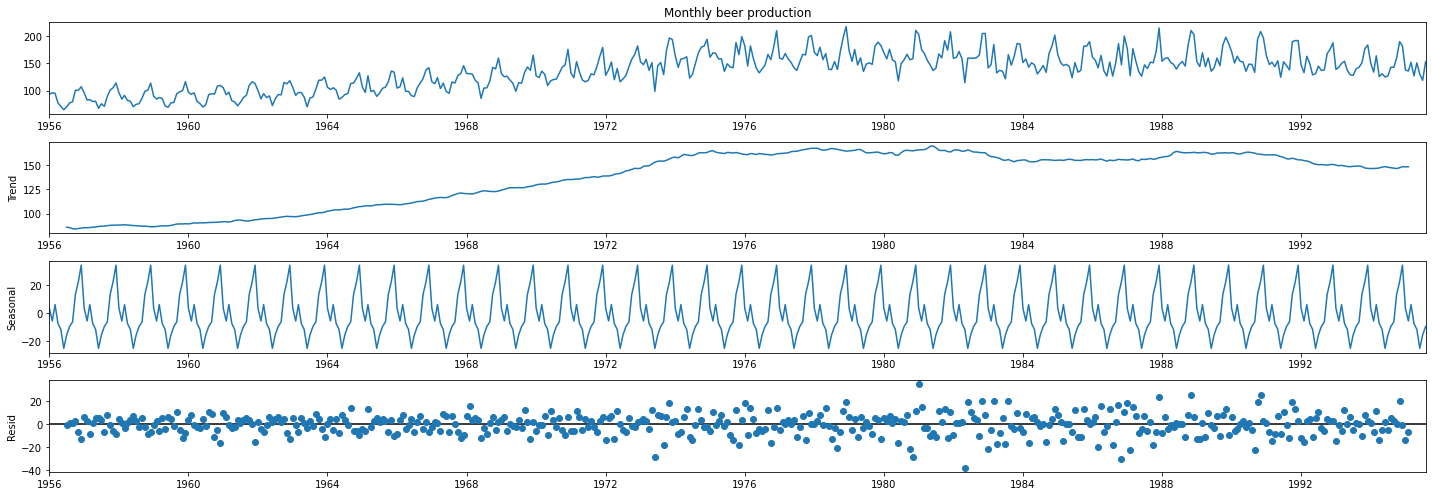

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose 

df_raw.Month = pd.to_datetime(df_raw.Month)
df_raw = df_raw.set_index("Month")
df_raw.index.freq = 'MS'
df_raw.index.format()
seasonal_decompose(x=df_raw.iloc[:,0], model = "additive").plot()
plt.show()

## Autocorrelation Plot

**Autocorrelation** measures the linear relationship between lagged values of a time series (similar to regular correlation),

$$r_k = \frac{\sum_{t=k+1}^{T} (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^{T} (y_t - \bar{y})^2}$$

For example, $r_1$ measures the relationship between $y_t$ and $y_{t-1}$, $r_2$ measures the relationship between $y_t$ and $y_{t-2}$, and so on.

If we treat $k$ as a functional input to the expression above, we call the resulting function the **autocorrelation function** (ACF), which we can plot.

The resulting plot is also called a *correlogram*.

We apply the ACF plot on the time series data and we can see that there is a 12-month seasonality observed in the data.

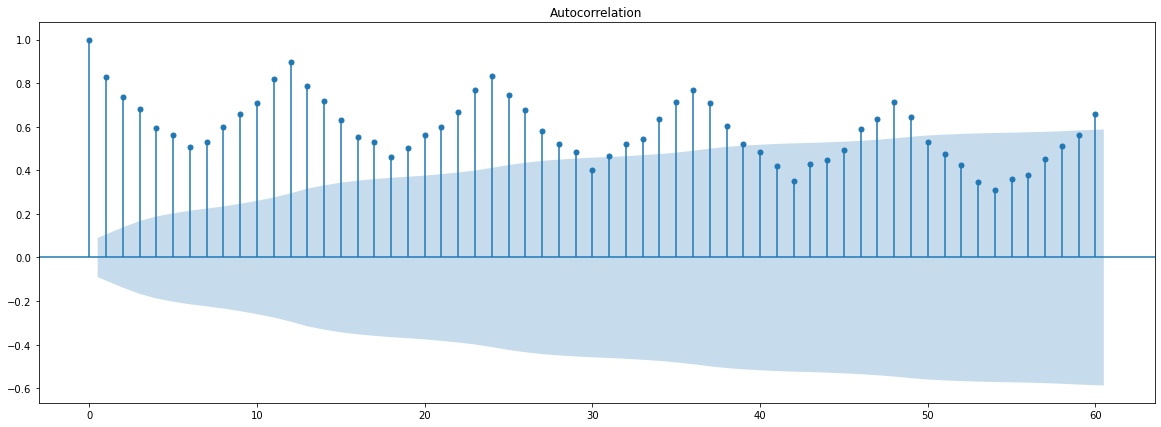

In [10]:
plot_acf(df_raw, lags=12*5)
plt.show()

`m = 12-month seasonality` 

When we plot the data for each year, we can see that there is a gradual decline in monthly beer production at the start of the year until the 6th month. However, after the 6th month, production starts to increase. 

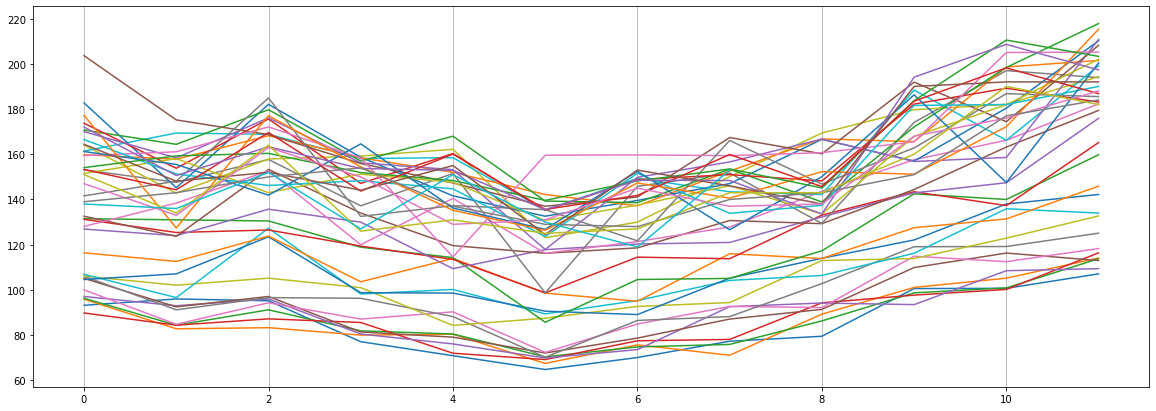

In [11]:
fig, ax = plt.subplots()

for year in df_raw.index.year.unique():
    ax.plot(df_raw[df_raw.index.year==year].iloc[:,0].to_list(), label=year)
plt.grid(which='major', axis='x')
# plt.legend()

## Stationary Version (12-Month differenced)

A requirement for `ARIMA` is that the data is stationary. In order to transform the data into its stationarized form, we do m-differencing. In this case, `m=12` since there is a 12-month seasonality observed. We can then use the `Augmented Dickey-Fuller test` to statistically check if the data is stationary. After differencing, the data is  stationary at a 5% confidence level.

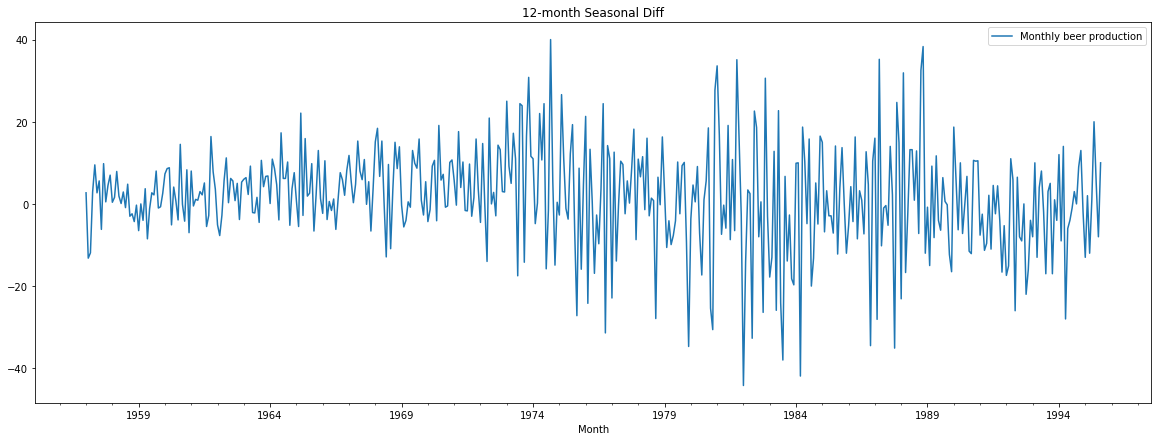

ADF = -2.896762
p-value = 0.045726
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [12]:
m = 12
ts_d = df_raw.diff(m)[m:]

ax = ts_d.plot()
ax.autoscale()
ax.set_title('12-month Seasonal Diff')
plt.show()

adf_test(ts_d)

**Stationary at the 5% level**

# Methodology

## Train-Test Split

For this project, the task is to predict a 12-month beer production. The data is split into test and train splits with the last 12 months being the test set, and the rest are used to train the models.

In [13]:
h = 12 # prediction horizon

ts_train = df_raw[:-h].iloc[:,0]
ts_test = df_raw[-h:].iloc[:,0]
ts_test

Month
1994-09-01    143.0
1994-10-01    160.0
1994-11-01    190.0
1994-12-01    182.0
1995-01-01    138.0
1995-02-01    136.0
1995-03-01    152.0
1995-04-01    127.0
1995-05-01    151.0
1995-06-01    130.0
1995-07-01    119.0
1995-08-01    153.0
Freq: MS, Name: Monthly beer production, dtype: float64

**Applying transformation (12-month differencing) on Train Data**

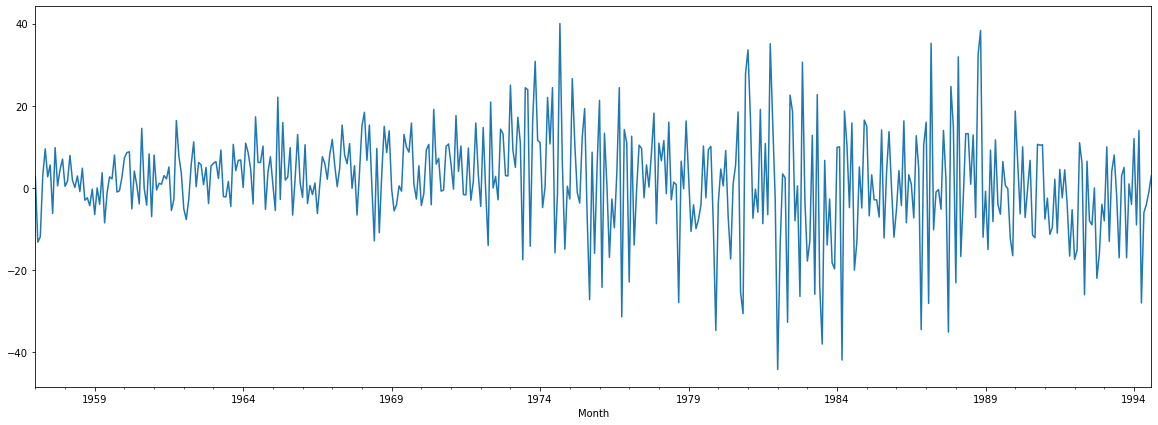

In [14]:
train_diff = ts_train.diff(m)[m:]
train_diff.plot()
plt.show()

## ARIMA

### Cross Validation

For cross validation, `sklearn`'s `TimeSeriesSplit` is used with a 5 fold split and a test size of 12 months. 

In [15]:
ts_train

Month
1956-01-01     93.2
1956-02-01     96.0
1956-03-01     95.2
1956-04-01     77.1
1956-05-01     70.9
              ...  
1994-04-01    126.0
1994-05-01    131.0
1994-06-01    125.0
1994-07-01    127.0
1994-08-01    143.0
Freq: MS, Name: Monthly beer production, Length: 464, dtype: float64

In [16]:
tskfold = TimeSeriesSplit(n_splits=5, test_size=h)
for train_index, val_index in tskfold.split(ts_train):
    print("Val Index:", val_index, end="--")
    print("Train length: ", len(train_index))
    # display(val_index)

Val Index: [404 405 406 407 408 409 410 411 412 413 414 415]--Train length:  404
Val Index: [416 417 418 419 420 421 422 423 424 425 426 427]--Train length:  416
Val Index: [428 429 430 431 432 433 434 435 436 437 438 439]--Train length:  428
Val Index: [440 441 442 443 444 445 446 447 448 449 450 451]--Train length:  440
Val Index: [452 453 454 455 456 457 458 459 460 461 462 463]--Train length:  452


The values for p and q are ranging from 0 to 4 while d values range from 0 to 2. Combinations of these values for p, d, and q will be tested and evaluated. The performance metric used is the mean absolute error. 

In [17]:
p_grid = range(4)
d_grid = range(2)
q_grid = range(4)
pdq_grid = list(itertools.product(p_grid, d_grid, q_grid))

df_results = pd.DataFrame()
df_results['(p,d,q)'] = pdq_grid
avg_mae = []

for pdq in pdq_grid:
    print(pdq) # swap this out for tqdm
    mae = []
    for train_index, val_index in tskfold.split(ts_train):
        
        # train-val split
        x_train = ts_train[train_index]
        y_val = ts_train[val_index]
        
        # log, s.diff
        x_d = x_train.diff(m)[m:] 
        
        # fit ARIMA
        model = ARIMA(x_d, order=pdq).fit()
        
        # forecast
        y_pred = model.forecast(h)
        
        # reverse log, s.diff
        y_pred = x_train[-m:].to_numpy() + y_pred.to_numpy()
        
        # compile error
        mae.append(mean_absolute_error(y_val, y_pred))
        
    # avg error
    avg_mae.append(np.mean(mae))

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 0, 3)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 1, 3)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 0, 3)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 0, 3)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(3, 0, 0)
(3, 0, 1)
(3, 0, 2)
(3, 0, 3)
(3, 1, 0)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)


Cross validation results show that the lowest average mean absolute error was achieved using a p-d-q combination of 1-1-2. The average mean absolute error is 8.55

In [18]:
df_results['Avg. MAE'] = avg_mae
df_results.sort_values(by='Avg. MAE')

(p,d,q)  Avg. MAE
14  (1, 1, 2)  8.553608
30  (3, 1, 2)  8.602071
19  (2, 0, 3)  8.603259
15  (1, 1, 3)  8.618031
31  (3, 1, 3)  8.663903
20  (2, 1, 0)  8.678092
28  (3, 1, 0)  8.701049
26  (3, 0, 2)  8.717302
27  (3, 0, 3)  8.741906
22  (2, 1, 2)  8.797928
29  (3, 1, 1)  8.842602
21  (2, 1, 1)  8.852917
5   (0, 1, 1)  8.872459
7   (0, 1, 3)  8.890724
23  (2, 1, 3)  8.895968
13  (1, 1, 1)  8.899131
6   (0, 1, 2)  8.918466
11  (1, 0, 3)  8.969716
12  (1, 1, 0)  9.218157
18  (2, 0, 2)  9.284378
10  (1, 0, 2)  9.289530
3   (0, 0, 3)  9.366359
0   (0, 0, 0)  9.421441
24  (3, 0, 0)  9.429658
16  (2, 0, 0)  9.441909
2   (0, 0, 2)  9.452797
8   (1, 0, 0)  9.453389
25  (3, 0, 1)  9.455264
1   (0, 0, 1)  9.460125
9   (1, 0, 1)  9.462207
17  (2, 0, 1)  9.463641
4   (0, 1, 0)  9.841667

### Testing Best ARIMA pdq : (1,1,2)

The best parameters are used to train the ARIMA model on the full train set and test it on the test set. 

In [19]:
ts_d = ts_train.diff(m)[m:] 

model = ARIMA(ts_d, order=(1,1,2)).fit()
y_pred = model.forecast(h)
y_pred = ts_train[-m:].to_numpy() + y_pred.to_numpy()

df_f = pd.DataFrame()
df_f['Actual'] = ts_test
df_f['Forecast'] = y_pred
df_f

Actual    Forecast
Month                         
1994-09-01   143.0  137.632464
1994-10-01   160.0  151.143535
1994-11-01   190.0  172.159377
1994-12-01   182.0  183.666999
1995-01-01   138.0  146.590351
1995-02-01   136.0  133.277231
1995-03-01   152.0  159.942854
1995-04-01   127.0  124.958431
1995-05-01   151.0  127.231174
1995-06-01   130.0  123.697678
1995-07-01   119.0  123.466996
1995-08-01   153.0  141.484402

### MAE

The mean absolute error is 8.42 when the optimal parameters are used. 

In [20]:
mean_absolute_error(df_f['Actual'], df_f['Forecast'])

8.423575855200594

### Actual vs Forecast Plot

Zooming in on the last 5 years of the dataset, the actual values and the predicted values from the ARIMA model are plotted together. The ARIMA produced good predictions as illustrated by the orange line in the plot. However, the predictions on the third spike were not as good.

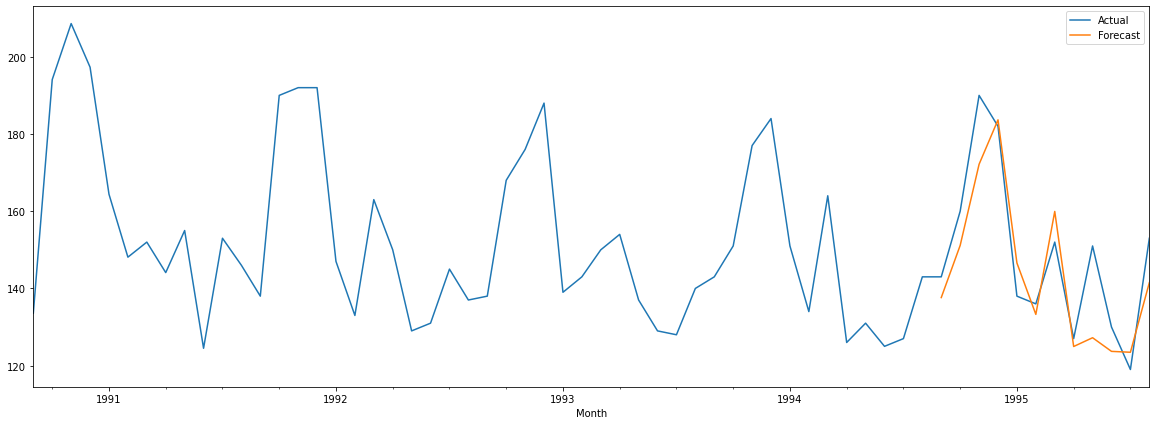

In [21]:
fig, ax = plt.subplots()
df_raw.rename(columns={'Monthly beer production': 'Actual'}).iloc[-5*m:,0].plot(ax=ax)
df_f['Forecast'].plot(ax=ax)
plt.legend()
plt.show()

## Prophet

Facebook developed Prophet,  an open sourcing forecasting tool available in both Python and R. It provides intuitive parameters which are easy to tune. Even someone who lacks deep expertise in time-series forecasting models can use this to generate meaningful predictions for a variety of problems in business scenarios. 

Prophet tries to capture daily, weekly and yearly seasonality along with holiday effects, implementing an additive regression model.

 It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is also robust to missing data and shifts in the trend, and typically handles outliers well.


Basically Prophet is framing the forecasting problem as a curve-fitting exercise rather than looking explicitly at the time based dependence of each observation within a time series.

<img src='prophet.png'>

At its core is the sum of three functions of time plus an error term

**The Growth Function (and change points):**

The growth function models the overall trend of the data. The old ideas should be familiar to anyone with a basic knowledge of linear and logistic functions. The new idea incorporated into Facebook prophet is that the growth trend can be present at all points in the data or can be altered at what Prophet calls “changepoints”.

Changepoints are moments in the data where the data shifts direction. Prophet can automatically detect change points or you can set them yourself. You can also adjust the power the change points have in altering the growth function and the amount of data taken into account in automatic changepoint detection.

**The Seasonality Function**

The seasonality function models seasonality using a Fourier Series as a function of time. This can approximate nearly any curve or in the case of Facebook Prophet, the seasonality (cyclical pattern) in our data. All together it looks like this:

<img src='f.png'>

**The Holiday/Event Function**

The holiday function allows Facebook Prophet to adjust forecasting when a holiday or major event may change the forecast. It takes a list of dates and when each date is present in the forecast adds or subtracts value from the forecast from the growth and seasonality terms based on historical data on the identified holiday dates. 

### Formatting the dataset

The prophet object requires a pandas dataframe to have a column labeled `ds` for the time stamps, and a column labeled `y` for the time series variable. Reformatting of the dataset is done to satisfy this condition.

In [22]:
df_prophet = df_raw.copy().reset_index()
df_prophet.columns = ['ds', 'y']
df_prophet

ds      y
0   1956-01-01   93.2
1   1956-02-01   96.0
2   1956-03-01   95.2
3   1956-04-01   77.1
4   1956-05-01   70.9
..         ...    ...
471 1995-04-01  127.0
472 1995-05-01  151.0
473 1995-06-01  130.0
474 1995-07-01  119.0
475 1995-08-01  153.0

[476 rows x 2 columns]

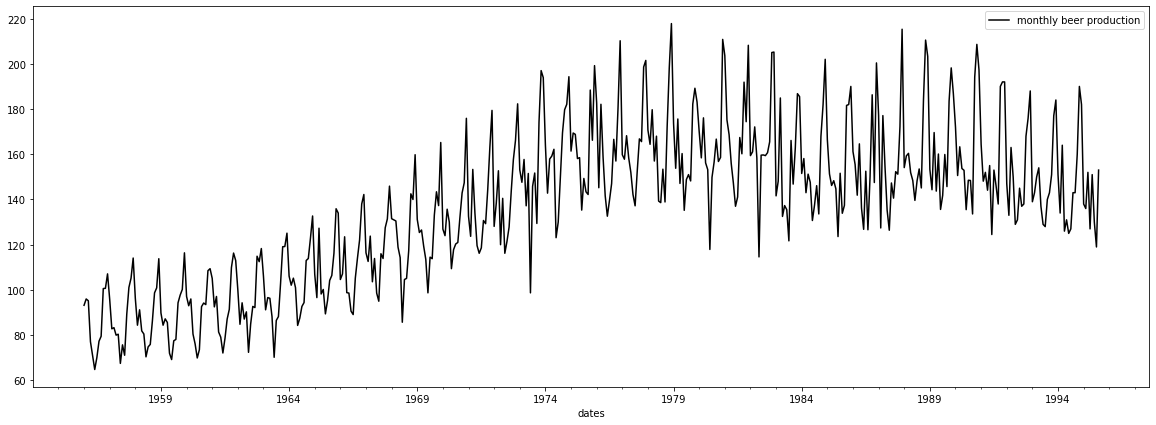

In [23]:
df_prophet.rename(columns={'y':'monthly beer production', 'ds':'dates'}).set_index('dates').plot(color='black')
plt.autoscale()
plt.show()

### Train-Test Split

A similar procedure is done to split the data into train and test splits. The last 12 months are to be used as the test set, and the remaining as the train set.

In [24]:
p_ts_train = df_prophet.iloc[:-12,:]
p_ts_test = df_prophet.iloc[-12:,:]
p_ts_train

ds      y
0   1956-01-01   93.2
1   1956-02-01   96.0
2   1956-03-01   95.2
3   1956-04-01   77.1
4   1956-05-01   70.9
..         ...    ...
459 1994-04-01  126.0
460 1994-05-01  131.0
461 1994-06-01  125.0
462 1994-07-01  127.0
463 1994-08-01  143.0

[464 rows x 2 columns]

Prophet has a `make_future_dataframe` function that takes in the prediction horizon and the frequency of your time series data. This returns a dataframe that contains the predicted values of prophet after you had trained it. 

In [25]:
p_model = Prophet()
p_model.fit(p_ts_train)
future = p_model.make_future_dataframe(periods=12,freq='MS')
future.tail(12)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
464 1994-09-01
465 1994-10-01
466 1994-11-01
467 1994-12-01
468 1995-01-01
469 1995-02-01
470 1995-03-01
471 1995-04-01
472 1995-05-01
473 1995-06-01
474 1995-07-01
475 1995-08-01

In [26]:
p_forecast = p_model.predict(future)
p_forecast[['ds', 'yhat']].tail(12)['yhat'].to_numpy()

array([145.08750174, 166.10492379, 173.72901471, 185.9779644 ,
       155.26057062, 146.81814626, 158.92397215, 143.18947774,
       139.6825521 , 127.10135435, 135.20720118, 141.67961164])

In [27]:
df_prophet

ds      y
0   1956-01-01   93.2
1   1956-02-01   96.0
2   1956-03-01   95.2
3   1956-04-01   77.1
4   1956-05-01   70.9
..         ...    ...
471 1995-04-01  127.0
472 1995-05-01  151.0
473 1995-06-01  130.0
474 1995-07-01  119.0
475 1995-08-01  153.0

[476 rows x 2 columns]

### Cross Validation

#### Parameters that can be tuned

`changepoint_prior_scale`<br>
- This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. If it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of 0.05 works for many time series, but this could be tuned; a range of [0.001, 0.5] would likely be about right.

`seasonality_prior_scale`<br>
 - This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. 

`holidays_prior_scale`<br>
- This controls flexibility to fit holiday effects. Similar to seasonality_prior_scale, it defaults to 10.0 which applies basically no regularization, since we usually have multiple observations of holidays and can do a good job of estimating their effects. This could also be tuned on a range of [0.01, 10] as with seasonality_prior_scale.

`seasonality_mode`<br>
- Options are ['additive', 'multiplicative']. Default is 'additive', but many business time series will have multiplicative seasonality. This is best identified just from looking at the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series (see the documentation here on multiplicative seasonality), but when that isn’t possible, it could be tuned.

In [28]:
# study.best_params

#### Tuning

In [29]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_range': [0.8, 0.85, 0.9, 0.95]
}
octoberfest = pd.DataFrame({
  'holiday': 'octoberfest',
  'ds': df_raw[df_raw.index.month==10].index,
})
octoberfest
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
avg_mae = []
# Use cross validation to evaluate all parameters
for params in all_params:
    mae = []
    for train_index, val_index in tskfold.split(p_ts_train):
        
        # train-val split
        x_train = p_ts_train.iloc[train_index,:]
        y_val = p_ts_train.iloc[val_index,:]['y']
        
        p_model = Prophet(**params, holidays=octoberfest).fit(x_train)  # Fit model with given params
        future = p_model.make_future_dataframe(periods=12,freq='MS')
        p_forecast = p_model.predict(future)
        y_pred = p_forecast[['ds', 'yhat']].tail(12)['yhat'].to_numpy()
        
        # compile error
        mae.append(mean_absolute_error(y_val, y_pred))
        
    # avg error
    avg_mae.append(np.mean(mae))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

After cross validation, the optimal parameters are the following: <br>

|        Parameter        |  Optimal Value |
|:-----------------------:|:--------------:|
| changepoint_prior_scale |       0.1      |
| seasonality_prior_scale |      0.01      |
|     seasonality_mode    | multiplicative |
|   holidays_prior_scale  |       1.0      |

In [30]:
best_p_params = np.argmin(avg_mae)
print(avg_mae[best_p_params])
print('best_params')
all_params[best_p_params]

8.428251576948801
best_params


{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 0.1,
 'seasonality_mode': 'multiplicative',
 'holidays_prior_scale': 0.01,
 'changepoint_range': 0.95}

### Testing

Using the optimal parameters, we train the model using the full train set and test it on the test set.

In [31]:
# final_p_model = Prophet(**study.best_params) # optuna

final_p_model = Prophet(changepoint_prior_scale=0.5,
                        seasonality_prior_scale=0.1,
                        seasonality_mode='multiplicative', 
                        holidays_prior_scale=0.01,
                        holidays=octoberfest,
                        changepoint_range=0.95) # itertools

final_p_model.fit(p_ts_train)
future = final_p_model.make_future_dataframe(periods=h,freq='MS')
future.tail(h)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
464 1994-09-01
465 1994-10-01
466 1994-11-01
467 1994-12-01
468 1995-01-01
469 1995-02-01
470 1995-03-01
471 1995-04-01
472 1995-05-01
473 1995-06-01
474 1995-07-01
475 1995-08-01

In [32]:
p_forecast = final_p_model.predict(future)
p_preds = p_forecast[['ds', 'yhat']].tail(h)['yhat'].to_numpy()
p_preds

array([136.00148604, 157.48310625, 165.78405178, 178.15975349,
       145.7794073 , 136.34679127, 149.03399566, 133.3408224 ,
       129.11361022, 115.63435234, 124.31565622, 130.23340325])

### MAE

The mean absolute error is then calculated. The value is 9.84.

In [33]:
p_mae = mean_absolute_error(p_preds, p_ts_test['y'])
p_mae

9.944909846630173

Prophet has a function `plot_components` that plots the components of the forecasts. The trend, holidays and seasonality is plotted below.

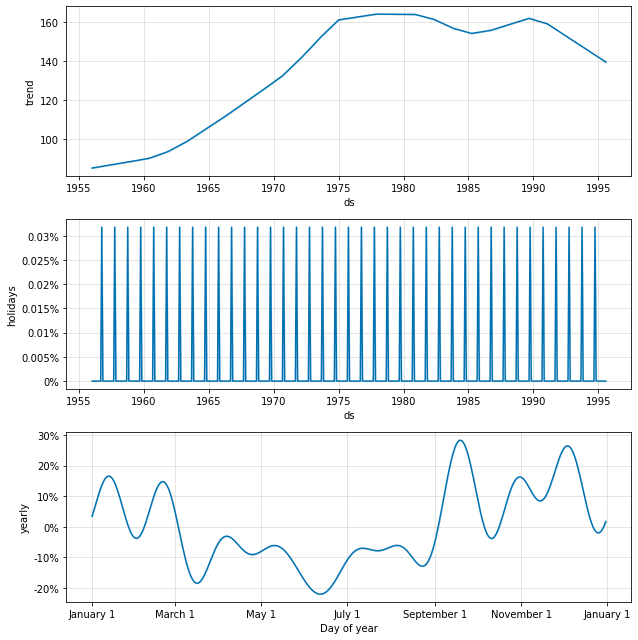

In [34]:
final_p_model.plot_components(p_forecast)
plt.show()

### Actual VS Forecast Plot

The predicted values are then plotted against the actual values. It can be seen that prophet did not do so well in predicting the values.

<AxesSubplot:xlabel='ds'>

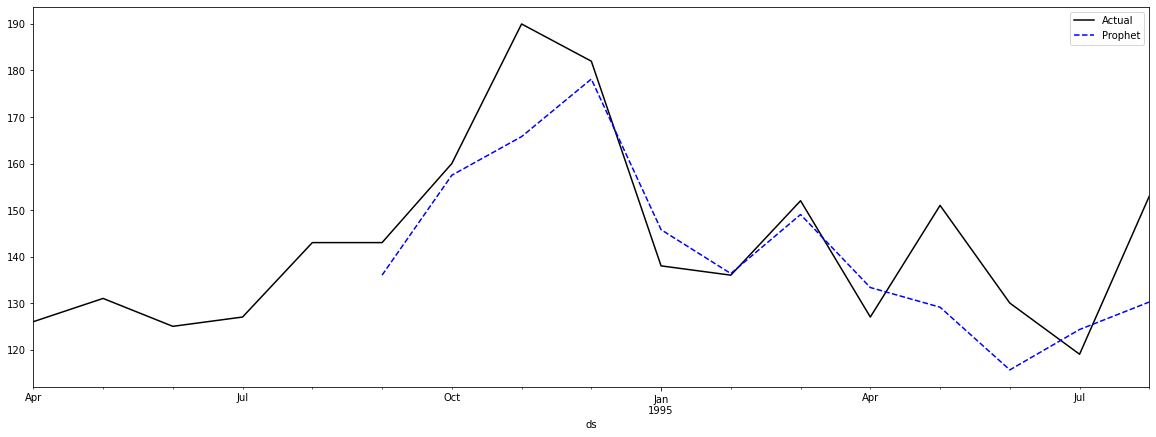

In [35]:
fig, ax = plt.subplots()

# df_raw.iloc[-5*h:,0].plot(ax=ax)
df_raw.rename(columns={'Monthly beer production': 'Actual'}).iloc[-h-5:,:].plot(ax=ax, color='black')
p_forecast[['ds', 'yhat']].tail(h).set_index('ds').rename(columns={'yhat':'Prophet'}).plot(ax=ax, ls='--', color='blue')

# Results and Discussion

Now that we have the forecasted values of ARIMA and Prophet, these are plotted against the actual values of the prediction horizon. Visually, it can be seen that ARIMA has indeed performed better. This is supported by the lower mean absolute values that it has produced.

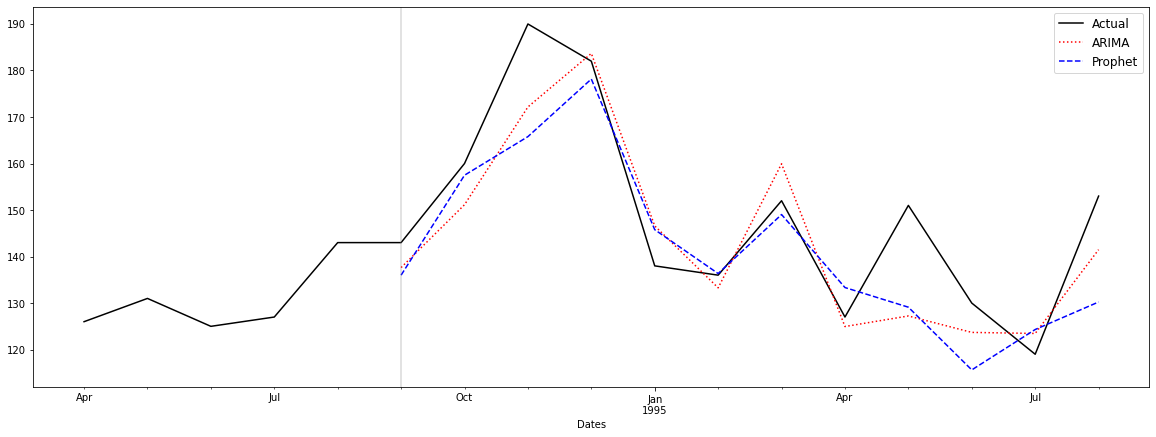

In [36]:
fig, ax = plt.subplots()

# df_raw.iloc[-5*h:,0].plot(ax=ax)
df_raw.rename(columns={'Monthly beer production': 'Actual'}).iloc[-h-5:,:].plot(ax=ax, color='black')
# df_f['Actual'].plot(ax=ax, color='black')
df_f['Forecast'].rename('ARIMA').plot(ax=ax, color='red', ls=':')
p_forecast[['ds', 'yhat']].tail(h).set_index('ds').rename(columns={'yhat':'Prophet'}).plot(ax=ax, ls='--', color='blue')
plt.axvline('1994-09-01', alpha=0.3, color='grey')
ax.set_xlabel('Dates')
plt.autoscale()
plt.legend(fontsize='large')

The results show that ARIMA is still the better model compared to Prophet. The predictions of ARIMA were closer to the actual values of the time series data. 

But why did Prophet not perform as good as ARIMA? Perhaps the characteristics of the data may not be suitable for Prophet. As mentioned, Prophet works best when there is multiple and strong seasonalities observed in the data. In addition, a data set that may have missing values and/or outliers would be a more suitable problem for Prophet to solve.

In this case, predicting monthly beer production was not the best problem for Prophet to solve. Only a 12-month seasonality was observed in the data. Moreover, there were not outlier instances as well or any missing data observed. 

A sequel for this project would be to test out ARIMA and Prophet on a different data set. The data should contain these characteristics that would supposedly allow Prophet to perform better. From this, we could really know for sure whether Prophet can outperform ARIMA on certain conditions.

# Conclusion

The project compares the performace of two time series algorithms to predict the last 12 months of a monthly beer production dataset from Kaggle. Exploratory Data Analysis was performed to transform the data set into data that satisfies the models' requirements. After tuning each model's hyperparameters using time series cross validation, the optimal hyperparameters were used to train and test the model. Results show that ARIMA outperformed Prophet with an MAE of 8.42 with Prophet having an MAE of 9.94. However, this single experiment does not fully answer whether ARIMA is indeed better than Prophet. In this case, ARIMA was the winner, however there may be problems that Prophet may perform better than ARIMA. It is recommended that testing these models on different datasets that have different characteristics is needed in order to determine whether ARIMA is indeed a better model overall compared to Prophet, or maybe Prophet is a better model on certain types of time series problems.

# References 

[Time Series Forecasting - ARIMA, LSTM, Prophet | Kaggle](https://www.kaggle.com/cdabakoglu/time-series-forecasting-arima-lstm-prophet/data)

[Monthly beer production | Kaggle](https://www.kaggle.com/sergiomora823/monthly-beer-production)

[Time Series Forecasting — ARIMA vs Prophet | by Krish Hariharan | Analytics Vidhya | Medium](https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-prophet-5015928e402a)

[Is Prophet Really Better than ARIMA for Forecasting Time Series Data? | by Hideaki Hayashi | learn data science (exploratory.io)](https://blog.exploratory.io/is-prophet-better-than-arima-for-forecasting-time-series-fa9ae08a5851)

[What is the difference between FB Prophet and ARIMA? - Quora](https://www.quora.com/What-is-the-difference-between-FB-Prophet-and-ARIMA)

[ARIMA vs. Prophet: Forecasting Air Passenger Numbers | by Michael Grogan | Towards Data Science](https://towardsdatascience.com/arima-vs-prophet-forecasting-air-passenger-numbers-4e01b2d93608)

[12.2 Prophet model | Forecasting: Principles and Practice (3rd ed) (otexts.com)](https://otexts.com/fpp3/prophet.html)

[GitHub - krishvictor77/Time-Series-Forecasting-ARIMA-vs-Prophet: Comparison between time series forecasting models such as ARIMA, Seasonal SARIMA and Prophet](https://github.com/krishvictor77/Time-Series-Forecasting-ARIMA-vs-Prophet)

[A Guide to Time Series Forecasting with Prophet in Python 3 | DigitalOcean](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3)

[Time series parameters finding using Prophet and Optuna bayesian optimization | by Pipe Salas Bravo | spikelab | Medium](https://medium.com/spikelab/time-series-parameters-finding-using-prophet-and-optuna-bayesian-optimization-e618614bd8b7)

[Diagnostics | Prophet (facebook.github.io)](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning)

[A Quick Start of Time Series Forecasting with a Practical Example using FB Prophet | by Yang Lyla | Towards Data Science](https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274)

[FAQ on Time Series Forecasting with Prophet (exploratory.io)](https://exploratory.io/note/hideaki/FAQ-on-Time-Series-Forecasting-with-Prophet-GuL5xAD0Uw#:~:text=Stationarity%20is%20an%20important%20condition,by%20definition%20do%20not%20have.)

[Predicting Apple Inc. Stock Prices Using Facebook's Prophet | Towards Data Science](https://towardsdatascience.com/predicting-apple-inc-stock-prices-using-facebooks-prophet-54ed6e91dbda)

[Time Series Analysis with Facebook Prophet: How it works and How to use it | by Mitchell Krieger | Towards Data Science](https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a)

[ARIMA vs. Prophet: Forecasting Air Passenger Numbers | by Michael Grogan | Towards Data Science](https://towardsdatascience.com/arima-vs-prophet-forecasting-air-passenger-numbers-4e01b2d93608)